# **1. Importing Libraries**




In [3]:
!pip install catboost
!pip install optuna
!pip install xgboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 929.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score as cv
from sklearn.tree import DecisionTreeRegressor
import optuna
import math
from datetime import datetime

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **2. Import Dataset**

In [5]:
df = pd.read_csv("./used_cars.csv")
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [6]:
# Remove "mi." and commas from the "milage" column and convert to numeric
df['milage'] = df['milage'].replace({' mi.': '', ',': ''}, regex=True).astype(int)

# Remove "$" and commas from the "price" column and convert to numeric
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(int)


In [7]:
df.describe()

,model_year,milage,price
count,4009.000000,4009.000000,4.009000e+03
mean,2015.515590,64717.551010,4.455319e+04
std,6.104816,52296.599459,7.871064e+04
min,1974.000000,100.000000,2.000000e+03
25%,2012.000000,23044.000000,1.720000e+04
50%,2017.000000,52775.000000,3.100000e+04
75%,2020.000000,94100.000000,4.999000e+04
max,2024.000000,405000.000000,2.954083e+06


In [8]:
df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   int64 
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   int64 
dtypes: int64(3), object(9)
memory usage: 376.0+ KB


# **3. Exploratory Data Analysis**

## **3.1. Missing Values**

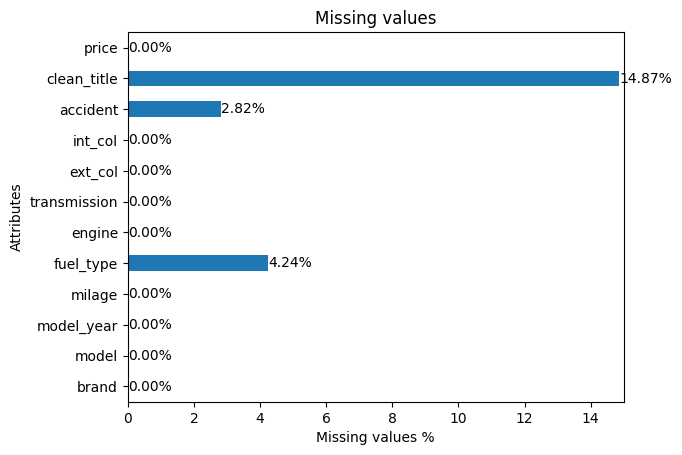

In [10]:
# Plotting the percentage of missing values as a horizontal bar chart
ax = (df.isnull().sum()/df.shape[0] * 100).plot(kind = "barh")

# Adding labels to the bars to show the percentage of missing values, formatted to two decimal places
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

# Setting the x-axis limit to display percentages from 0 to 15
plt.xlim((0, 15))

# Labeling the y-axis as "Attributes"
plt.ylabel("Attributes")

# Labeling the x-axis as "Missing values %"
plt.xlabel("Missing values %")

# Adding a title to the plot: "Missing values"
plt.title("Missing values")
plt.show()

**Conclusion**

Only 3 attributes have missing values.

*   clean_title: 4.87%
*   accident: 2.82%
*   fuel_type: 4.24%




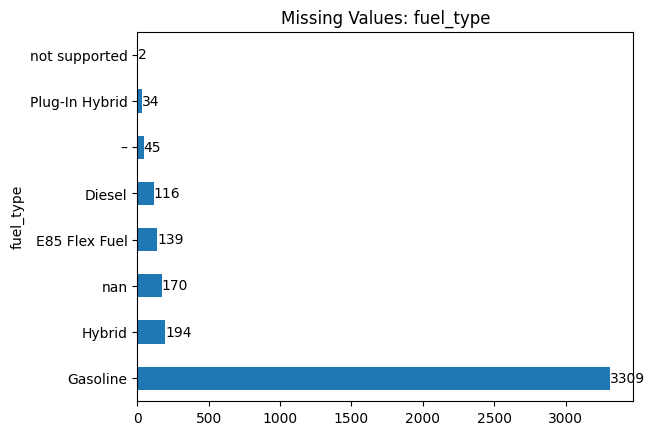

In [11]:
# fuel_type attribute investigation
ax = df["fuel_type"].value_counts(dropna = False).plot(kind = "barh")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Missing Values: fuel_type");

In [12]:
df["fuel_type"].unique()

array(['E85 Flex Fuel', 'Gasoline', 'Hybrid', nan, 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [13]:
df[(df["fuel_type"].isna()) | (df["fuel_type"] == "not supported") | (df["fuel_type"] == "–")].to_csv("to_process.csv")

**Conclusion**

Manually processed the missing fuel type with the data of engine details. Few of the records are still having missing and unwanted values. Dropping those records due to lack of more information.

In [14]:
# Load the dataset and set 'Unnamed: 0' as the index
processed_fuel_type_df = pd.read_csv("./to_process.csv", index_col="Unnamed: 0")

# Display the first few rows to confirm the change
processed_fuel_type_df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
9,Tesla,Model X Long Range Plus,2020,34000,NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,69950
44,Lucid,Air Grand Touring,2022,3552,NaN,536.0HP Electric Motor Electric Fuel System,1-Speed A/T,Red,Beige,None reported,Yes,119999
68,Lucid,Air Grand Touring,2022,4900,NaN,536.0HP Electric Motor Electric Fuel System,1-Speed A/T,Red,Black,None reported,Yes,99000
92,Rivian,R1S Adventure Package,2023,2800,NaN,835.0HP Electric Motor Electric Fuel System,1-Speed A/T,White,Green,None reported,Yes,92000
122,Rivian,R1S Adventure Package,2023,2500,NaN,835.0HP Electric Motor Electric Fuel System,A/T,Green,White,None reported,Yes,94000


In [15]:
for index,row in processed_fuel_type_df.iterrows():
    df.iloc[index, df.columns.get_loc('fuel_type')] = row["fuel_type"]

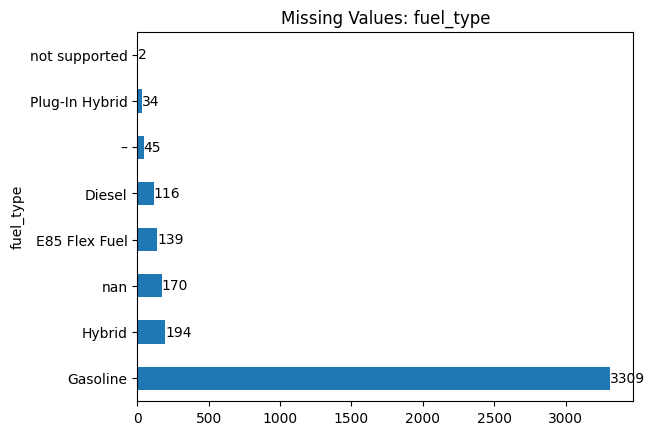

In [16]:
ax = df["fuel_type"].value_counts(dropna = False).plot(kind = "barh")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Missing Values: fuel_type");

Dropping improper rows based fuel_type attribute

In [17]:
df = df[(~df["fuel_type"].isna()) & (df["fuel_type"] != "–")]
df["fuel_type"].unique()

array(['E85 Flex Fuel', 'Gasoline', 'Hybrid', 'Diesel', 'Plug-In Hybrid',
       'not supported'], dtype=object)

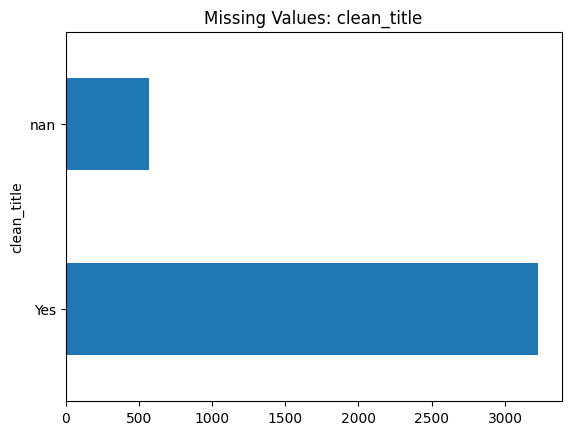

In [18]:
df["clean_title"].value_counts(dropna = False).plot(kind = "barh")
plt.title("Missing Values: clean_title");

 **Conclusion**

Since we have Yes and null values, let's consider the null values as No

Replacing null values with No

In [19]:
df["clean_title"] = df["clean_title"].fillna("No")

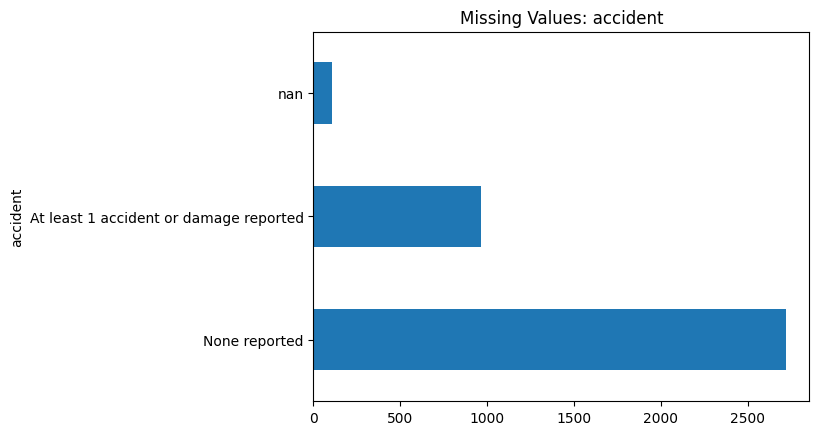

In [20]:
df["accident"].value_counts(dropna = False).plot(kind = "barh")
plt.title("Missing Values: accident");

**Conclusion**

Since we only have few unique values, one of them being null, considering null values as 'No data'

In [21]:
df["accident"] = df["accident"].fillna("No data")

**Resolving discrepencies in attributes¶**

Checking for discrepencies in other attritues

In [22]:
df["brand"].unique()

array(['Ford', 'Hyundai', 'Lexus', 'INFINITI', 'Audi', 'Acura', 'BMW',
       'Land', 'Aston', 'Toyota', 'Lincoln', 'Jaguar', 'Mercedes-Benz',
       'Dodge', 'Nissan', 'Genesis', 'Chevrolet', 'Kia', 'Jeep',
       'Bentley', 'Honda', 'MINI', 'Porsche', 'Hummer', 'Chrysler',
       'Volvo', 'Cadillac', 'Lamborghini', 'Maserati', 'Volkswagen',
       'Subaru', 'GMC', 'RAM', 'Alfa', 'Ferrari', 'Scion', 'Mitsubishi',
       'Mazda', 'Saturn', 'Bugatti', 'Rolls-Royce', 'McLaren', 'Buick',
       'Lotus', 'Pontiac', 'FIAT', 'Saab', 'Mercury', 'Plymouth', 'smart',
       'Maybach', 'Suzuki'], dtype=object)

**Conclusion**

No discrepencies found

**model attribute**

In [23]:
df[df["model"]== "–"].shape

(0, 12)

**Conclusion**

No discrepencies found

**model_year attribute**

<Axes: xlabel='model_year'>

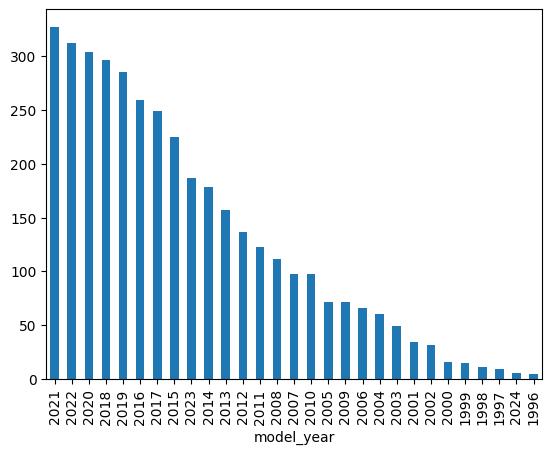

In [24]:
df["model_year"].value_counts().plot(kind= "bar")

**Conclusion**

No discrepencies found

**milage aatribute**

<Axes: ylabel='Frequency'>

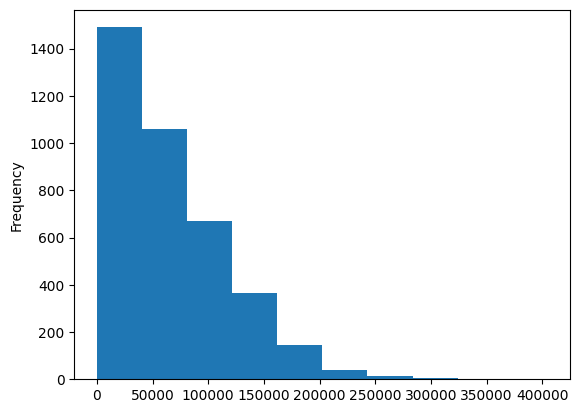

In [25]:
df["milage"].plot(kind= "hist")


**Conclusion**

No discrepencies found

**engine attribute**

In [26]:
df["engine"].unique()

array(['300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capability',
       '3.8L V6 24V GDI DOHC', '3.5 Liter DOHC', ...,
       '136.0HP 1.8L 4 Cylinder Engine Gasoline Fuel',
       '270.0HP 2.0L 4 Cylinder Engine Gasoline Fuel',
       '420.0HP 5.9L 12 Cylinder Engine Gasoline Fuel'], dtype=object)

In [27]:
df[df["engine"]== "–"].shape

(0, 12)

**Conclusion**

engine attribute contains '–' value. Droppig the rows containing this value

In [28]:
df = df[~(df["engine"]== "–")]

**transmission attribute**

In [29]:
df["transmission"].unique()

array(['6-Speed A/T', '8-Speed Automatic', 'Automatic', '7-Speed A/T',
       'F', 'A/T', '8-Speed A/T', 'Transmission w/Dual Shift Mode',
       '9-Speed Automatic', '6-Speed M/T', '10-Speed A/T', '9-Speed A/T',
       '5-Speed A/T', 'Automatic CVT',
       '7-Speed Automatic with Auto-Shift', 'CVT-F', 'M/T',
       '6-Speed Automatic with Auto-Shift', '10-Speed Automatic',
       'CVT Transmission', '4-Speed A/T', '6-Speed Automatic',
       '4-Speed Automatic', '7-Speed M/T',
       '8-Speed Automatic with Auto-Shift', '5-Speed Automatic',
       '8-SPEED AT', '1-Speed Automatic', '5-Speed M/T', 'Manual',
       '6-Speed Manual', 'Variable', '2', '7-Speed Manual',
       'Automatic, 9-Spd 9G-Tronic', 'Automatic, 8-Spd',
       'Automatic, 8-Spd Sport w/Sport & Manual Modes', '–',
       'Auto, 6-Spd w/CmdShft', 'Transmission Overdrive Switch',
       '7-Speed Automatic', 'Automatic, 8-Spd PDK Dual-Clutch',
       'Automatic, 8-Spd M STEPTRONIC w/Drivelogic, Sport & Manual Modes',
  

In [30]:
df[df["transmission"]=="SCHEDULED FOR OR IN PRODUCTION"]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
2620,BMW,X6 xDrive40i,2021,72903,Hybrid,3.0 Liter Turbo,SCHEDULED FOR OR IN PRODUCTION,Black Sapphire Metallic,Black,At least 1 accident or damage reported,No,53998


In [31]:
df[df["transmission"]=="2"]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
269,Acura,TLX w/A-Spec Package,2022,14896,Gasoline,2.0 Liter DOHC Turbo,2,Lunar Silver Metallic,Ebony,None reported,No,39998
516,Acura,MDX w/Technology Package,2022,30177,Gasoline,3.5L 24V SOHC I-VTEC V6,2,Majestic Black Pearl,Espresso,None reported,No,46598
2381,Acura,RDX PMC Edition,2021,44457,Gasoline,2.0 Liter Turbo,2,Majestic Black Pearl,Ebony,None reported,No,40598


**Conclusion**

Dropping entries with '2' and 'SCHEDULED FOR OR IN PRODUCTION' due to insufficient data

In [32]:
df = df[~(df["transmission"].isin(["2", "SCHEDULED FOR OR IN PRODUCTION"]))]

**int_col attribute**

In [33]:
df["int_col"].unique()

array(['Black', 'Gray', 'Ebony.', 'Green', 'Pimento / Ebony', 'Brown',
       'White', '–', 'Beige', 'Jet Black', 'Light Gray', 'Anthracite',
       'Red', 'Nero Ade', 'Blue', 'Charcoal', 'Rioja Red',
       'Canberra Beige/Black', 'Roast', 'Ivory / Ebony',
       'Silk Beige/Black', 'Medium Pewter', 'Ice', 'Black / Express Red',
       'Obsidian Black', 'Ebony', 'Orange', 'Caramel', 'Orchid',
       'Graphite', 'Tan/Ebony', 'Cappuccino', 'Nero', 'Sahara Tan',
       'BLACK', 'Hotspur', 'Blk', 'Nougat Brown', 'Titan Black',
       'Oyster W/Contrast', 'Macchiato Beige/Black', 'Sand Beige',
       'Navy Pier', 'WHITE', 'Parchment.', 'Sarder Brown', 'Grace White',
       'Cloud', 'Mesa', 'Whisper Beige', 'Medium Dark Slate', 'Gold',
       'Camel Leather', 'Tupelo', 'Black/Red', 'Parchment', 'Beluga Hide',
       'Charles Blue', 'Global Black', 'Titan Black / Quarzit', 'Mocha',
       'Portland', 'Medium Light Camel', 'Black / Saddle', 'Ash',
       'Ebony / Pimento', 'Tan', 'Mistral Gra

In [34]:
df[df["int_col"] == "–"].shape

(126, 12)

**Conclusion**

int_col attribute contains '–' value. Droppig the rows containing this value

In [35]:
df = df[~(df["int_col"] == "–")]

**ext_col attribute**

In [36]:
df["ext_col"].unique()

array(['Black', 'Moonlight Cloud', 'Blue', 'Glacier White Metallic',
       'Silver', 'Green', 'Fuji White', 'Yellow', 'White', 'Gray',
       'Iconic Silver Metallic', 'Mythos Black Metallic', 'Red', 'Gold',
       'Lunar Silver Metallic', 'Mountain Air Metallic', 'Caspian Blue',
       'Tango Red Metallic', 'Alpine White', 'BLU ELEOS', 'Horizon Blue',
       'Granite Crystal Clearcoat Metallic', 'Orange', 'Beige',
       'Rift Metallic', 'Atomic Silver', 'Summit White',
       'Imperial Blue Metallic', 'Magnetic Gray Clearcoat',
       'Bright White Clearcoat', 'Typhoon Gray', 'Crystal Black Silica',
       'Arctic Gray Metallic', 'Selenite Grey Metallic', 'Ultra Black',
       'Lunare White Metallic', 'Hyper Red', 'Daytona Gray Pearl Effect',
       'Vik Black', 'Pacific Blue Metallic', 'Obsidian Black Metallic',
       'Silver Ice Metallic', 'Sonic Silver Metallic', 'Nightfall Mica',
       'Apex Blue', 'Go Mango!', 'Ingot Silver Metallic',
       'Midnight Black Metallic', 'Black 

**Conclusion**

No discrepencies found

**transmission attribute**

In [37]:
df["transmission"].unique()

array(['6-Speed A/T', '8-Speed Automatic', 'Automatic', '7-Speed A/T',
       'F', 'A/T', '8-Speed A/T', 'Transmission w/Dual Shift Mode',
       '9-Speed Automatic', '10-Speed A/T', '9-Speed A/T', '5-Speed A/T',
       'Automatic CVT', '6-Speed M/T',
       '7-Speed Automatic with Auto-Shift', 'M/T',
       '6-Speed Automatic with Auto-Shift', '10-Speed Automatic',
       'CVT Transmission', '4-Speed A/T', '6-Speed Automatic',
       '4-Speed Automatic', '7-Speed M/T',
       '8-Speed Automatic with Auto-Shift', '5-Speed Automatic',
       '8-SPEED AT', '1-Speed Automatic', '5-Speed M/T', '6-Speed Manual',
       'Variable', '7-Speed Manual', 'Automatic, 9-Spd 9G-Tronic',
       'Automatic, 8-Spd Sport w/Sport & Manual Modes',
       'Transmission Overdrive Switch', 'Automatic, 8-Spd',
       '7-Speed Automatic', 'Automatic, 8-Spd PDK Dual-Clutch',
       'Automatic, 8-Spd M STEPTRONIC w/Drivelogic, Sport & Manual Modes',
       '6-Speed', '7-Speed', 'Automatic, 7-Spd S tronic Dual-Cl

**price attribute**

<Axes: ylabel='Frequency'>

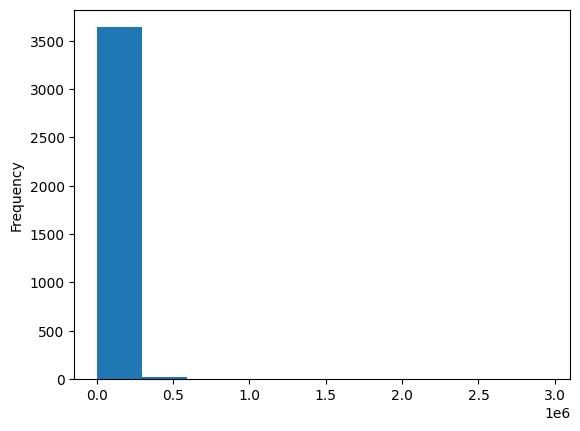

In [38]:
df["price"].plot(kind="hist")

**Conclusion**

No discrepencies found

**Extracting HP form engine type**

In [39]:
def extract_hp(x):
    matches = re.findall("\\b(\d*[.]\d*)(?=HP\\b)", x)
    if(len(matches) == 0):
        return 0
    else:
        return float(matches[0])

In [40]:
df["hp"] = df["engine"].apply(extract_hp)
df["hp"].isnull().sum()

0

**Extracting engine capacity**

In [41]:
def extract_engine_capacity(x):
    matches = re.findall("\\b(\d*[.]\d*)(?=L\\b)", x)
    if(len(matches) == 0):
        return 0
    else:
        return float(matches[0])


In [42]:
df["engine_capacity"] = df["engine"].apply(extract_engine_capacity)
df["engine_capacity"].isnull().sum()

0

**Extracting No. of Cylinders**

In [43]:
def extract_cylinder(x):
    matches = re.findall("\\b\d+(?= Cylinder\\b)", x)
    if(len(matches) == 0):
        return 0
    else:
        return int(matches[0])

In [44]:
df["cylinders"] = df["engine"].apply(extract_cylinder)
df["cylinders"].unique()

array([ 0,  4,  8, 12,  6,  3,  5, 10])

**Extracting transmission type**

In [45]:
def extract_transmission_type(x):
    data = None
    if(re.search("(Automatic|A\/T|AT|At)", x) != None):
        data = "Automatic"
    if(re.search("(Manual|M\/T|MT|Mt)", x) != None):
        data = "Manual"
    if(re.search("(CVT|Variable)", x) != None ):
        data = "CVT"
    if("DCT" in x):
        data = "DCT"
    if(data == None):
        data = "Other"

    return data

In [46]:
df["transmission"] = df["transmission"].apply(extract_transmission_type)
df["transmission"].unique()

array(['Automatic', 'Other', 'CVT', 'Manual'], dtype=object)

**Extracting exterior color**

In [47]:
def get_matplot_color(colors):
    for color in colors.split():
        if(color.lower() in matplotlib.colors.cnames.keys()):
            return color.lower()
    return color.lower()

In [48]:
df["ext_col"] = df["ext_col"].apply(get_matplot_color)
df["ext_col"].unique()

array(['black', 'cloud', 'blue', 'white', 'silver', 'green', 'yellow',
       'gray', 'red', 'gold', 'metallic', 'eleos', 'orange', 'beige',
       'grey', 'mica', 'mango!', 'monocerus', 'verde', 'pearl', 'blu',
       'brown', 'tintcoat', 'snow', '–', 'maroon', 'ice', 'pearlcoat',
       'onyx', 'chalk', 'purple', 'moss', 'tan', 'pink', 'yulong',
       'corsa', 'sea', 'platinum', 'caviar', 'plum', 'isis', 'crimson',
       'blueprint', 'sapphire', 'chromaflair', 'granite', 'tricoat',
       'noctis', 'ember', 'nimbus', 'clearcoat', 'matte', 'color',
       'borealis', 'rosso', 'rock', 'c'], dtype=object)

In [49]:
top_10_ext_cols = df["ext_col"].value_counts(ascending=False).index[:10]
top_10_ext_cols

Index(['black', 'white', 'gray', 'silver', 'blue', 'red', 'green', 'metallic',
       'gold', 'brown'],
      dtype='object', name='ext_col')

In [50]:
def top_10_cols(x, cols):
    if x in cols:
        return x
    else:
        return "other"

In [51]:
df["ext_col"] = df["ext_col"].apply(lambda x: top_10_cols(x, top_10_ext_cols))
df["ext_col"].unique()

array(['black', 'other', 'blue', 'white', 'silver', 'green', 'gray',
       'red', 'gold', 'metallic', 'brown'], dtype=object)

**Extracting interior color**

In [52]:
df["int_col"] = df["int_col"].apply(get_matplot_color)
df["int_col"].unique()

array(['black', 'gray', 'ebony.', 'green', 'ebony', 'brown', 'white',
       'beige', 'anthracite', 'red', 'ade', 'blue', 'charcoal',
       'beige/black', 'roast', 'ivory', 'pewter', 'ice', 'orange',
       'caramel', 'orchid', 'graphite', 'tan/ebony', 'cappuccino', 'nero',
       'tan', 'hotspur', 'blk', 'w/contrast', 'navy', 'parchment.',
       'cloud', 'mesa', 'slate', 'gold', 'leather', 'tupelo', 'black/red',
       'parchment', 'hide', 'mocha', 'portland', 'camel', 'ash',
       'pimento', 'silver', 'graystone', 'sandstone', 'stone',
       'macchiato', 'boulder', 'walnut', 'espresso', 'auburn',
       'tan/ebony/ebony', 'amber', 'orange/black', 'titanium', 'platinum',
       'stitch', 'shale', 'red/black', 'cypress', 'ceramic', 'galvanized',
       'yellow', 'metal', 'brandy', 'linen', 'porpoise', 'oyster/black',
       'gideon', 'chestnut', 'polar', 'garnet', 'accents', 'dune',
       'beluga', 'sport', 'black/graphite', 'macchiato/magmagrey',
       'chateau', 'tension', 'cas

In [53]:
top_10_int_cols = df["int_col"].value_counts(ascending=False).index[:10]
top_10_int_cols

Index(['black', 'beige', 'gray', 'brown', 'red', 'white', 'ebony', 'blue',
       'orange', 'silver'],
      dtype='object', name='int_col')

In [54]:
df["int_col"] = df["int_col"].apply(lambda x: top_10_cols(x, top_10_int_cols))
df["int_col"].unique()

array(['black', 'gray', 'other', 'ebony', 'brown', 'white', 'beige',
       'red', 'blue', 'orange', 'silver'], dtype=object)

**Brand vs Avg Price**

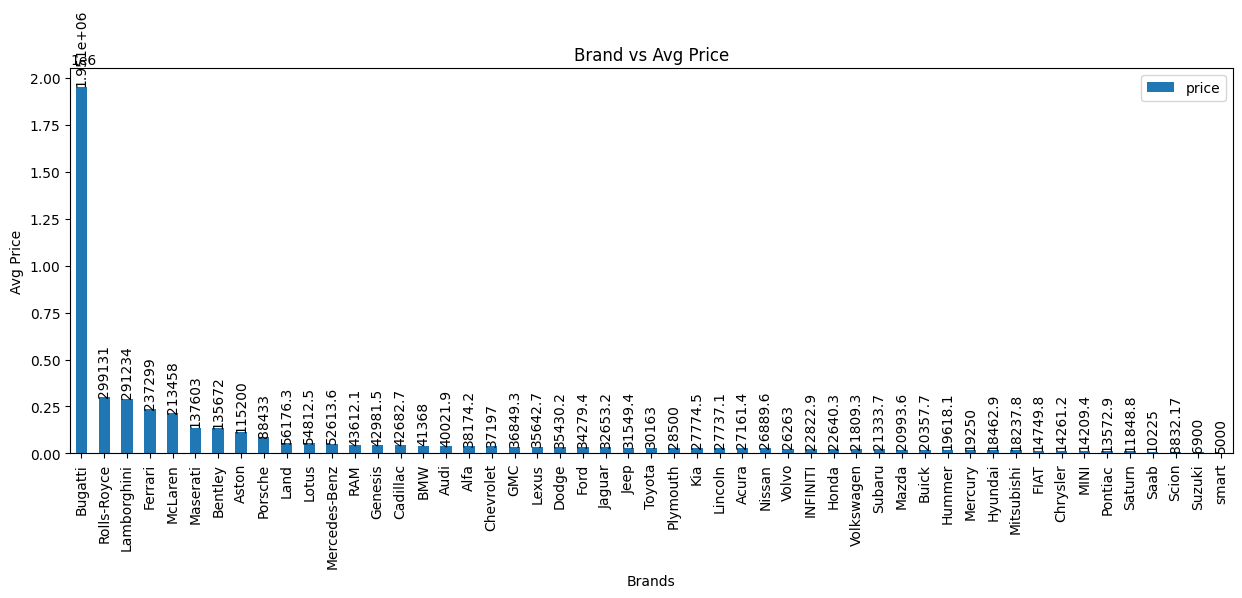

In [55]:
temp = df[["brand","price"]].groupby("brand").mean().sort_values("price",ascending = False)
ax = temp.plot(kind="bar", figsize=(15, 5))
for container in ax.containers:
    ax.bar_label(container, rotation = 90)
plt.ylabel("Avg Price")
plt.xlabel("Brands")
plt.title("Brand vs Avg Price");

In [56]:
car_index = df[["brand","price"]].groupby("brand").mean().sort_values("price",ascending = False).index
car_index

Index(['Bugatti', 'Rolls-Royce', 'Lamborghini', 'Ferrari', 'McLaren',
       'Maserati', 'Bentley', 'Aston', 'Porsche', 'Land', 'Lotus',
       'Mercedes-Benz', 'RAM', 'Genesis', 'Cadillac', 'BMW', 'Audi', 'Alfa',
       'Chevrolet', 'GMC', 'Lexus', 'Dodge', 'Ford', 'Jaguar', 'Jeep',
       'Toyota', 'Plymouth', 'Kia', 'Lincoln', 'Acura', 'Nissan', 'Volvo',
       'INFINITI', 'Honda', 'Volkswagen', 'Subaru', 'Mazda', 'Buick', 'Hummer',
       'Mercury', 'Hyundai', 'Mitsubishi', 'FIAT', 'Chrysler', 'MINI',
       'Pontiac', 'Saturn', 'Saab', 'Scion', 'Suzuki', 'smart'],
      dtype='object', name='brand')

In [57]:
luxury_car_brand = car_index[:7]
premium_car_brand = car_index[7:24]
expensive_car_brand = car_index[24:47]
cheap_car_brand = car_index[47:]

In [58]:
luxury_car_brand, premium_car_brand, expensive_car_brand, cheap_car_brand

(Index(['Bugatti', 'Rolls-Royce', 'Lamborghini', 'Ferrari', 'McLaren',
        'Maserati', 'Bentley'],
       dtype='object', name='brand'),
 Index(['Aston', 'Porsche', 'Land', 'Lotus', 'Mercedes-Benz', 'RAM', 'Genesis',
        'Cadillac', 'BMW', 'Audi', 'Alfa', 'Chevrolet', 'GMC', 'Lexus', 'Dodge',
        'Ford', 'Jaguar'],
       dtype='object', name='brand'),
 Index(['Jeep', 'Toyota', 'Plymouth', 'Kia', 'Lincoln', 'Acura', 'Nissan',
        'Volvo', 'INFINITI', 'Honda', 'Volkswagen', 'Subaru', 'Mazda', 'Buick',
        'Hummer', 'Mercury', 'Hyundai', 'Mitsubishi', 'FIAT', 'Chrysler',
        'MINI', 'Pontiac', 'Saturn'],
       dtype='object', name='brand'),
 Index(['Saab', 'Scion', 'Suzuki', 'smart'], dtype='object', name='brand'))

**Conclusion**


*   We can see that Brands with higher avg prices are mostly sports cars (like Bugatti, Lamborghini) and luxury cars like (Rolls Royce and Bentley)

*   Bugatti has comparitively higher avg price as expected

*   While Scion which was a sub brand of Toyota has lowest avg price - as the brand was disconitinued and most of the models were absorbed to Toyota's line up


**Top 10 Brands with Highest Avg Pricing**

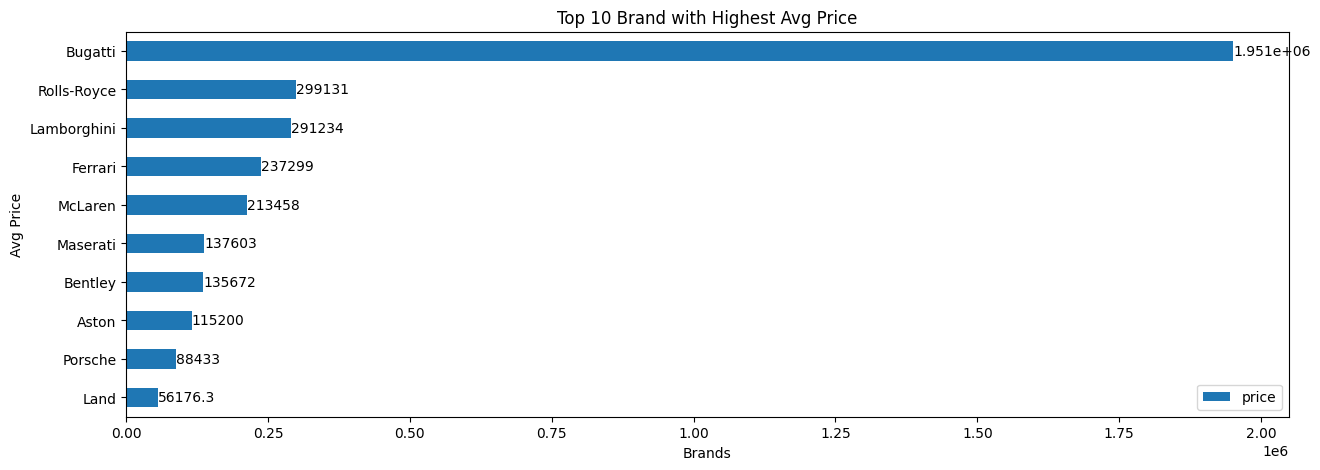

In [59]:
temp = df[["brand","price"]].groupby("brand").mean().sort_values("price",ascending = True).tail(10)
ax = temp.plot(kind="barh", figsize=(15, 5))
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel("Avg Price")
plt.xlabel("Brands")
plt.title("Top 10 Brand with Highest Avg Price");

**Brands vs No. of Listings**

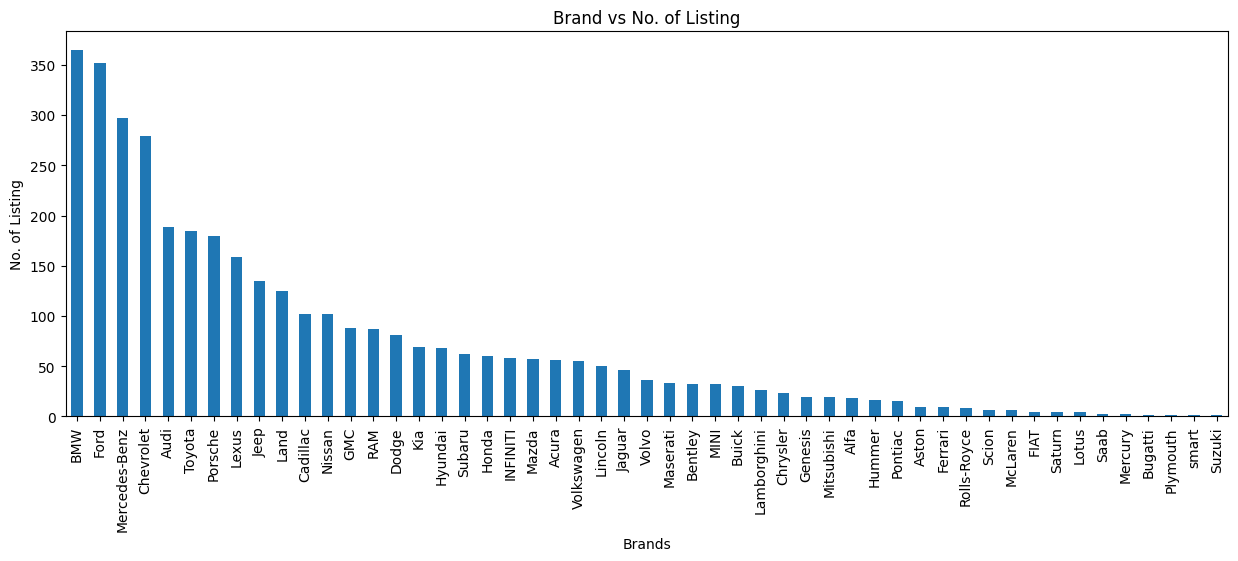

In [60]:
df["brand"].value_counts().plot(kind="bar", figsize=(15, 5))
plt.ylabel("No. of Listing")
plt.xlabel("Brands")
plt.title("Brand vs No. of Listing");

**Conclusion**

*   Ford has highest number of listings making it common in the used market
*   Mercedes Benz, BMW and Chevrolet follows Ford


**Top 10 Brands with Highest No. of Listings**

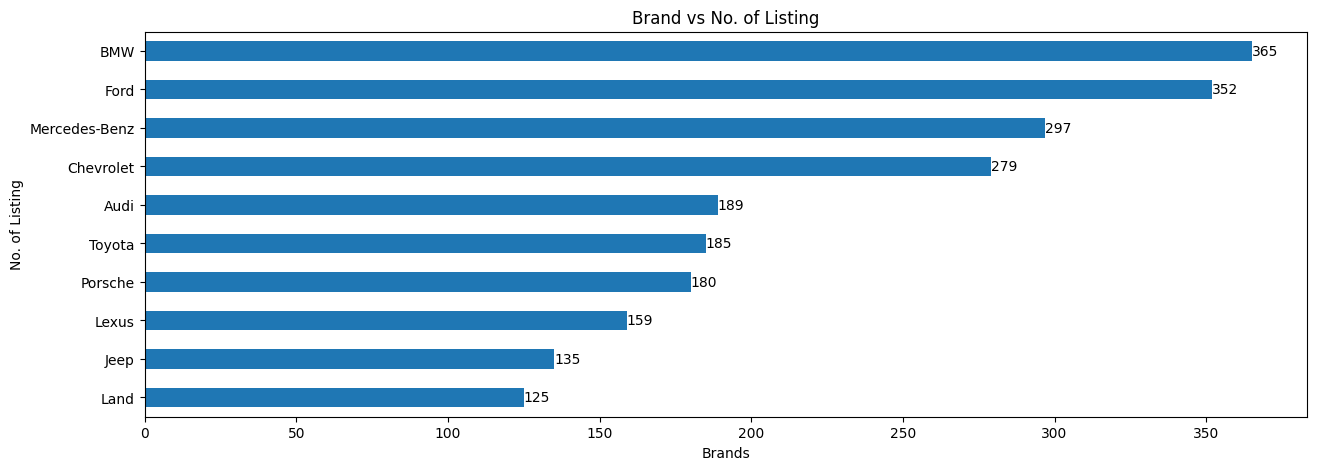

In [61]:
ax = df["brand"].value_counts(ascending=True).tail(10).plot(kind="barh", figsize=(15, 5))
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel("No. of Listing")
plt.xlabel("Brands")
plt.title("Brand vs No. of Listing");

**Analysis on Top 10 Brands vs Accidents**

In [62]:
def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() + 200
            ax.annotate(percentage, (x, y), size = 8)
    plt.show()

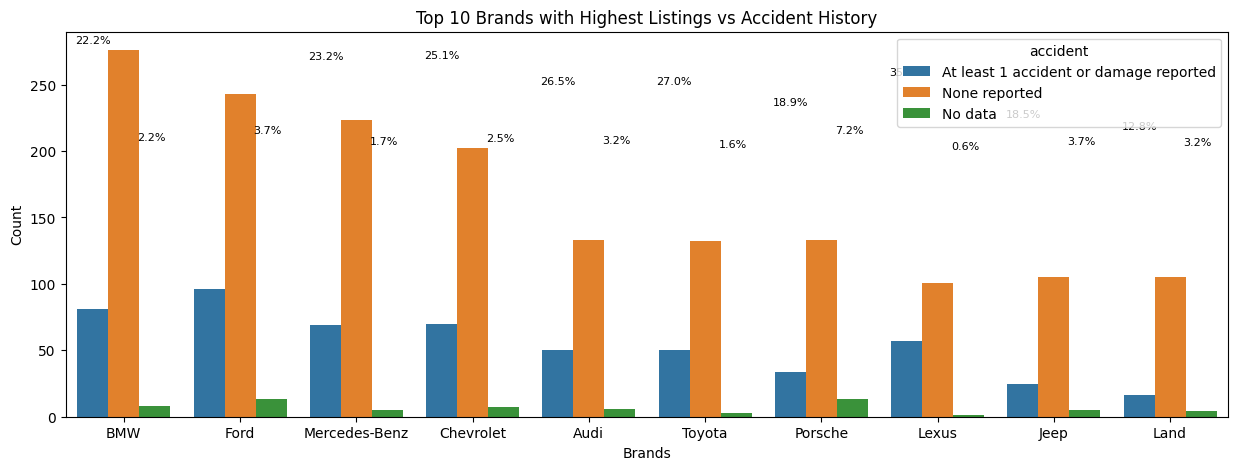

In [63]:
top_10_df = df[df["brand"].isin(list(df["brand"].value_counts().head(10).index))]
order = df["brand"].value_counts().head(10).index
plt.figure(figsize=(15,5))
ax = sns.countplot(top_10_df, x = "brand", hue = "accident", order=order)
plt.xlabel("Brands")
plt.ylabel("Count")
plt.title("Top 10 Brands with Highest Listings vs Accident History")
with_hue(ax, df["brand"], 10, 3)

# **4. Data Preparation**

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3664 entries, 0 to 4008
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            3664 non-null   object 
 1   model            3664 non-null   object 
 2   model_year       3664 non-null   int64  
 3   milage           3664 non-null   int64  
 4   fuel_type        3664 non-null   object 
 5   engine           3664 non-null   object 
 6   transmission     3664 non-null   object 
 7   ext_col          3664 non-null   object 
 8   int_col          3664 non-null   object 
 9   accident         3664 non-null   object 
 10  clean_title      3664 non-null   object 
 11  price            3664 non-null   int64  
 12  hp               3664 non-null   float64
 13  engine_capacity  3664 non-null   float64
 14  cylinders        3664 non-null   int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 458.0+ KB


**Preparing Brand Category Attribute**

In [65]:
def brand_category(x):
    if x in luxury_car_brand:
        return "luxury"
    elif x in premium_car_brand:
        return "premium"
    elif x in expensive_car_brand:
        return "expensive"
    elif x in cheap_car_brand:
        return "cheap"
    return "other"

In [66]:
df["brand_category"] = df["brand"].apply(brand_category)
df["brand_category"].head()

,brand_category
0,premium
1,expensive
2,premium
3,expensive
4,premium


**Preparing Brand Attribute**

In [67]:
top_10_pricing_cars = df[["brand","price"]].groupby("brand").mean().sort_values("price",ascending = True).tail(10).index
top_10_listing_cars = df["brand"].value_counts(ascending=True).tail(10).index

In [68]:
def prepare_brand_value(x):
    if(x in top_10_pricing_cars or x in top_10_listing_cars):
        return x
    else:
        return "Other"

In [69]:
df["brand"] = df["brand"].apply(prepare_brand_value)
df["brand"].value_counts()

,count
brand,
Other,1274
BMW,365
Ford,352
Mercedes-Benz,297
Chevrolet,279
Audi,189
Toyota,185
Porsche,180
Lexus,159


**Extracting Age Attribute from model_year**

In [70]:
def extract_age(x):
    return datetime.now().year - x

In [71]:
df["age"] = df["model_year"].apply(extract_age)
df["age"].head()

,age
0,11
1,3
2,2
3,9
4,3


# **4.1. One Hot Encoding Categorical Values**

In [72]:
def one_hot_encode(df, categories, other_col = None):
    data = []
    col = df.columns[0]
    for value in df[col].values:
        cat_map = {}
        for cat in categories:
            if(cat == other_col):
                continue
            cat_map[col + "_" + cat] = 0
        if(col + "_" + value in cat_map):
            cat_map[col + "_" + value] = 1
        data.append(cat_map)
    result = pd.DataFrame.from_dict(data)
    result.index = df.index
    return result

In [73]:
df = pd.concat([df, one_hot_encode(df[["brand"]], df["brand"].unique(), other_col="Other")], axis=1, ignore_index=False)
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,brand_Chevrolet,brand_Jeep,brand_Bentley,brand_Porsche,brand_Lamborghini,brand_Maserati,brand_Ferrari,brand_Bugatti,brand_McLaren,brand_Rolls-Royce
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,Automatic,black,black,At least 1 accident or damage reported,...,0,0,0,0,0,0,0,0,0,0
1,Other,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,Automatic,other,gray,At least 1 accident or damage reported,...,0,0,0,0,0,0,0,0,0,0
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,3.5 Liter DOHC,Automatic,blue,black,None reported,...,0,0,0,0,0,0,0,0,0,0
3,Other,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,Automatic,black,black,None reported,...,0,0,0,0,0,0,0,0,0,0
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,Automatic,white,black,None reported,...,0,0,0,0,0,0,0,0,0,0


In [74]:
df = pd.concat([df, one_hot_encode(df[["brand_category"]], df["brand_category"].unique(), other_col="other")], axis=1, ignore_index=False)
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,brand_Lamborghini,brand_Maserati,brand_Ferrari,brand_Bugatti,brand_McLaren,brand_Rolls-Royce,brand_category_premium,brand_category_expensive,brand_category_luxury,brand_category_cheap
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,Automatic,black,black,At least 1 accident or damage reported,...,0,0,0,0,0,0,1,0,0,0
1,Other,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,Automatic,other,gray,At least 1 accident or damage reported,...,0,0,0,0,0,0,0,1,0,0
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,3.5 Liter DOHC,Automatic,blue,black,None reported,...,0,0,0,0,0,0,1,0,0,0
3,Other,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,Automatic,black,black,None reported,...,0,0,0,0,0,0,0,1,0,0
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,Automatic,white,black,None reported,...,0,0,0,0,0,0,1,0,0,0


In [75]:
df = pd.concat([df, one_hot_encode(df[["transmission"]], df["transmission"].unique(), other_col="Other")], axis=1, ignore_index=False)
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,brand_Bugatti,brand_McLaren,brand_Rolls-Royce,brand_category_premium,brand_category_expensive,brand_category_luxury,brand_category_cheap,transmission_Automatic,transmission_CVT,transmission_Manual
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,Automatic,black,black,At least 1 accident or damage reported,...,0,0,0,1,0,0,0,1,0,0
1,Other,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,Automatic,other,gray,At least 1 accident or damage reported,...,0,0,0,0,1,0,0,1,0,0
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,3.5 Liter DOHC,Automatic,blue,black,None reported,...,0,0,0,1,0,0,0,1,0,0
3,Other,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,Automatic,black,black,None reported,...,0,0,0,0,1,0,0,1,0,0
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,Automatic,white,black,None reported,...,0,0,0,1,0,0,0,1,0,0


In [76]:
df = pd.concat([df, one_hot_encode(df[["fuel_type"]], df["fuel_type"].unique(), other_col="not supported")], axis=1, ignore_index=False)
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,brand_category_luxury,brand_category_cheap,transmission_Automatic,transmission_CVT,transmission_Manual,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Diesel,fuel_type_Plug-In Hybrid
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,Automatic,black,black,At least 1 accident or damage reported,...,0,0,1,0,0,1,0,0,0,0
1,Other,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,Automatic,other,gray,At least 1 accident or damage reported,...,0,0,1,0,0,0,1,0,0,0
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,3.5 Liter DOHC,Automatic,blue,black,None reported,...,0,0,1,0,0,0,1,0,0,0
3,Other,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,Automatic,black,black,None reported,...,0,0,1,0,0,0,0,1,0,0
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,Automatic,white,black,None reported,...,0,0,1,0,0,0,1,0,0,0


In [77]:
df = pd.concat([df, one_hot_encode(df[["accident"]], df["accident"].unique(), other_col="No data")], axis=1, ignore_index=False)
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,transmission_Automatic,transmission_CVT,transmission_Manual,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Diesel,fuel_type_Plug-In Hybrid,accident_At least 1 accident or damage reported,accident_None reported
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,Automatic,black,black,At least 1 accident or damage reported,...,1,0,0,1,0,0,0,0,1,0
1,Other,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,Automatic,other,gray,At least 1 accident or damage reported,...,1,0,0,0,1,0,0,0,1,0
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,3.5 Liter DOHC,Automatic,blue,black,None reported,...,1,0,0,0,1,0,0,0,0,1
3,Other,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,Automatic,black,black,None reported,...,1,0,0,0,0,1,0,0,0,1
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,Automatic,white,black,None reported,...,1,0,0,0,1,0,0,0,0,1


In [78]:
df = pd.concat([df, one_hot_encode(df[["clean_title"]], df["clean_title"].unique())], axis=1, ignore_index=False)
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,transmission_Manual,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Diesel,fuel_type_Plug-In Hybrid,accident_At least 1 accident or damage reported,accident_None reported,clean_title_Yes,clean_title_No
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,Automatic,black,black,At least 1 accident or damage reported,...,0,1,0,0,0,0,1,0,1,0
1,Other,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,Automatic,other,gray,At least 1 accident or damage reported,...,0,0,1,0,0,0,1,0,1,0
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,3.5 Liter DOHC,Automatic,blue,black,None reported,...,0,0,1,0,0,0,0,1,0,1
3,Other,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,Automatic,black,black,None reported,...,0,0,0,1,0,0,0,1,1,0
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,Automatic,white,black,None reported,...,0,0,1,0,0,0,0,1,0,1


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3664 entries, 0 to 4008
Data columns (total 51 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   brand                                            3664 non-null   object 
 1   model                                            3664 non-null   object 
 2   model_year                                       3664 non-null   int64  
 3   milage                                           3664 non-null   int64  
 4   fuel_type                                        3664 non-null   object 
 5   engine                                           3664 non-null   object 
 6   transmission                                     3664 non-null   object 
 7   ext_col                                          3664 non-null   object 
 8   int_col                                          3664 non-null   object 
 9   accident                           

**Dropping Unwanted Columns**

In [80]:
cols_to_drop = ["model", "engine", "ext_col", "int_col", "accident", "fuel_type", "clean_title", "brand", "brand_category", "transmission", "model_year"]
train_df = df.drop(cols_to_drop, axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3664 entries, 0 to 4008
Data columns (total 40 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   milage                                           3664 non-null   int64  
 1   price                                            3664 non-null   int64  
 2   hp                                               3664 non-null   float64
 3   engine_capacity                                  3664 non-null   float64
 4   cylinders                                        3664 non-null   int64  
 5   age                                              3664 non-null   int64  
 6   brand_Ford                                       3664 non-null   int64  
 7   brand_Lexus                                      3664 non-null   int64  
 8   brand_Audi                                       3664 non-null   int64  
 9   brand_BMW                          

# **5. Modeling**

In [81]:
x = train_df.drop("price", axis = 1)
y = df["price"]

## **5.1. Model Selection**

**Gradient Boosting**

In [82]:
math.sqrt(cv(GradientBoostingRegressor(), x, y, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean() * -1)

66543.01259674464

**ElasticNet**

In [83]:
math.sqrt(cv(ElasticNet(), x, y, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean() * -1)

74543.96463323629

**SGD Regressor Model**

In [84]:
math.sqrt(cv(SGDRegressor(), x, y, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean() * -1)

3.863347312271905e+18

**CatBoost Model**

In [85]:
# model4 = CatBoostRegressor(iterations = 200, learning_rate=0.07)
math.sqrt(cv(CatBoostRegressor(iterations = 500, learning_rate=0.019, verbose=500), x, y, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean() * -1)

66820.89041305296

**XGB Model**

In [86]:
math.sqrt(cv(XGBRegressor(), x, y, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean() * -1)


63676.06225192998

**LGBMRegressor Model¶**

In [87]:
math.sqrt(cv(LGBMRegressor(), x, y, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean() * -1)

64587.63062001381

**Final Model & Optimization - Optuna**

In [88]:
# GB Regressor
def objective_gb(trial):
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 50, 500),
        "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.3),
        "max_depth": trial.suggest_int('max_depth', 2, 10),
        "min_samples_split": trial.suggest_int('min_samples_split', 2, 5),
        "min_samples_leaf": trial.suggest_int('min_samples_leaf', 1, 5),
        "subsample": trial.suggest_float('subsample', 0.4, 0.8)
    }

    model = GradientBoostingRegressor(**params)
    return math.sqrt(cv(model, x, y, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean() * -1)

In [89]:
# cat regressor
def objective_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.3),
        "iterations": trial.suggest_int('iterations', 100, 2000),
        "depth": trial.suggest_int('depth', 4, 10),
        "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 0.03, 10.0),
        "random_strength": trial.suggest_float('random_strength', 0.5, 10),
        "bagging_temperature": trial.suggest_float('bagging_temperature', 0.0, 1.0)
    }

    model = LB(**params, verbose=0)
    return math.sqrt(cv(model, x, y, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean() * -1)

In [96]:
model_cat = CatBoostRegressor(iterations = 500, learning_rate=0.019, verbose=0)
model_cat.fit(x, y)

**Prediction on test data¶**

In [90]:
def transform_df(test_df, train_cols):
    test_df["age"] = test_df["model_year"].apply(extract_age)
    test_df["fuel_type"] = test_df["fuel_type"].fillna("not supported")
    test_df["fuel_type"] = test_df["fuel_type"].replace({"–":"not supported"})
    test_df["accident"] = test_df["accident"].fillna("No data")
    test_df["accident"] = test_df["accident"].replace({"–":"No data"})
    test_df["clean_title"] = test_df["clean_title"].fillna("No")
    test_df["clean_title"] = test_df["clean_title"].replace({"–":"No"})
    test_df["hp"] = test_df["engine"].apply(extract_hp)
    test_df["brand_category"] = test_df["brand"].apply(brand_category)
    test_df["brand"] = test_df["brand"].apply(prepare_brand_value)
    test_df["engine_capacity"] = test_df["engine"].apply(extract_engine_capacity)
    test_df["cylinders"] = test_df["engine"].apply(extract_cylinder)
    test_df["transmission"] = test_df["transmission"].apply(extract_transmission_type)
    test_df["ext_col"] = test_df["ext_col"].apply(get_matplot_color)
    test_df["ext_col"] = test_df["ext_col"].apply(lambda x: top_10_cols(x, top_10_ext_cols))
    test_df["int_col"] = test_df["int_col"].apply(get_matplot_color)
    test_df["int_col"] = test_df["int_col"].apply(lambda x: top_10_cols(x, top_10_int_cols))
#     test_df = extract_availability(df = test_df, threshold=OrderedDict({"common":500, "moderate":100, "rare":0}), else_label = "rare")
    test_df = pd.concat([test_df, one_hot_encode(test_df[["brand"]], df["brand"].unique(), other_col="Other")], axis=1, ignore_index=False)
    test_df = pd.concat([test_df, one_hot_encode(test_df[["brand_category"]], df["brand_category"].unique(), other_col="other")], axis=1, ignore_index=False)
    test_df = pd.concat([test_df, one_hot_encode(test_df[["transmission"]], df["transmission"].unique(), other_col="Other")], axis=1, ignore_index=False)
    test_df = pd.concat([test_df, one_hot_encode(test_df[["fuel_type"]], df["fuel_type"].unique(), other_col="not supported")], axis=1, ignore_index=False)
#     test_df = pd.concat([test_df, one_hot_encode(test_df[["availability"]], df["availability"].unique())], axis=1, ignore_index=False)
#     test_df = pd.concat([test_df, one_hot_encode(test_df[["ext_col"]], df["ext_col"].unique(), other_col="other")], axis=1, ignore_index=False)
#     test_df = pd.concat([test_df, one_hot_encode(test_df[["int_col"]], df["int_col"].unique(), other_col="other")], axis=1, ignore_index=False)
    test_df = pd.concat([test_df, one_hot_encode(test_df[["accident"]], df["accident"].unique(), other_col="No data")], axis=1, ignore_index=False)
    test_df = pd.concat([test_df, one_hot_encode(test_df[["clean_title"]], df["clean_title"].unique())], axis=1, ignore_index=False)
    test_df = test_df.drop(cols_to_drop, axis=1)

    return test_df[train_cols]



In [92]:
test_df = pd.read_csv("test.csv", index_col="id")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125690 entries, 188533 to 314222
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         125690 non-null  object
 1   model         125690 non-null  object
 2   model_year    125690 non-null  int64 
 3   milage        125690 non-null  int64 
 4   fuel_type     122307 non-null  object
 5   engine        125690 non-null  object
 6   transmission  125690 non-null  object
 7   ext_col       125690 non-null  object
 8   int_col       125690 non-null  object
 9   accident      124058 non-null  object
 10  clean_title   111451 non-null  object
dtypes: int64(2), object(9)
memory usage: 11.5+ MB


In [93]:
test_df = transform_df(test_df, train_cols=x.columns)

In [94]:
test_df.head()

,milage,hp,engine_capacity,cylinders,age,brand_Ford,brand_Lexus,brand_Audi,brand_BMW,brand_Land,...,transmission_Manual,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Diesel,fuel_type_Plug-In Hybrid,accident_At least 1 accident or damage reported,accident_None reported,clean_title_Yes,clean_title_No
id,,,,,,,,,,,,,,,,,,,,,
188533,98000,240.0,2.0,4,9,0,0,0,0,1,...,0,0,1,0,0,0,0,1,1,0
188534,9142,395.0,3.0,6,4,0,0,0,0,1,...,0,0,0,1,0,0,0,1,1,0
188535,28121,0.0,3.5,0,2,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
188536,61258,0.0,0.0,0,8,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
188537,59000,252.0,2.0,4,6,0,0,1,0,0,...,0,0,1,0,0,0,0,1,1,0


In [97]:
predict_cat = model_cat.predict(test_df)
# predict_gb = model_gb.predict(test_df)

In [98]:
# prediction = predict_gb * 0.6 + predict_cat * 0.4
prediction = predict_cat
prediction[:5]

array([19165.06355984, 66330.49489997, 46942.79428894, 26850.29850037,
       26378.51901221])

In [99]:
result_df = pd.DataFrame(prediction)
result_df.index = test_df.index
result_df.to_csv("submission.csv")